In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from matplotlib.patches import Ellipse
import scipy.stats as stats

C:\Users\benra\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [6]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
from sklearn.metrics import adjusted_rand_score

# --- Configuration ---
# Base directory where your experiment folders are located
base_data_dir = r"C:\Users\benra"
# Path to your basin mask NetCDF file
basin_mask_path = r"C:\Users\benra\output_combined_masked_basins.nc"

# List of all experiment IDs
experiment_ids = [
    'exp05','exp06', 'exp07', 'exp08', 'exp09', 'exp10', 'expa01', 'expa02', 'expa03'
]

# List of all model names (NetCDF file names within each experiment folder, without .nc)
participating_models = [
    'AWI_ISSM1', 'AWI_ISSM2', 'AWI_ISSM3', 'BGC_BISICLES', 'GSFC_ISSM',
    'ILTS_PIK_SICOPOLIS1', 'ILTS_PIK_SICOPOLIS2', 'IMAU_IMAUICE1', 'IMAU_IMAUICE2', 'JPL_ISSM',
    'JPL_ISSMPALEO', 'LSCE_GRISLI', 'MUN_GSM1', 'MUN_GSM2', 'NCAR_CISM',
    'UAF_PISM1', 'UAF_PISM2', 'UCIJPL_ISSM1', 'UCIJPL_ISSM2', 'VUB_GISM', 'VUW_PISM'
]

# Variable name for ice thickness in your NetCDF files
variable_name = 'lithk'

# PCA and K-means parameters
n_components_pca = 4  # For 2D plotting and clustering
n_clusters_kmeans = 5 # Number of clusters for K-means

# Output directory for plots
base_output_dir = "Research_Plots"
os.makedirs(base_output_dir, exist_ok=True)

output_plots_dir = os.path.join(base_output_dir, "Basin_ARI_Analysis_Plots")
os.makedirs(output_plots_dir, exist_ok=True)

# --- Basin Geographic Names Mapping ---
basin_names = {
    1: 'NO',
    2: 'NE',
    3: 'CE',
    4: 'SE',
    5: 'SW',
    6: 'CW',
    7: 'NW'
}

# --- Define Marker Styles for Models ---
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'h', 'v', '<', '>', 'p', 'H', 'd', '8', 'v', '^', '<', '>', 'P', '+']
model_to_marker = {model: markers[i % len(markers)] for i, model in enumerate(participating_models)}

# --- Load Basin Mask ---
try:
    basin_mask_data = xr.open_dataset(basin_mask_path)

    basin_id_var_name = None
    for var_key in basin_mask_data.data_vars.keys():
        if var_key.strip() == 'IDs':
            basin_id_var_name = var_key
            break
    
    if basin_id_var_name is None:
        raise KeyError("Could not find 'IDs' variable (even after stripping whitespace) in basin mask NetCDF.")

    basin_ids_grid = basin_mask_data[basin_id_var_name]
    unique_basin_ids = np.unique(basin_ids_grid.values[~np.isnan(basin_ids_grid.values)]).astype(int)
    print(f"Found {len(unique_basin_ids)} unique basins: {unique_basin_ids}")

    # Get grid coordinates and shape from the basin mask (assuming it's on the same grid)
    x_coords_grid = basin_ids_grid['x'].values if 'x' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[1]].values
    y_coords_grid = basin_ids_grid['y'].values if 'y' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[0]].values
    rows_grid, cols_grid = basin_ids_grid.shape
except FileNotFoundError:
    print(f"Error: Basin mask file not found at {basin_mask_path}")
    exit()
except KeyError as e:
    print(f"Error: {e}. Please check the variable name or file path for the basin mask.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading basin mask: {e}")
    exit()


# --- Main Analysis Loop: Per Basin ---
for basin_id in unique_basin_ids:
    # Get the geographic name for the current basin, default to number if not found
    basin_geo_name = basin_names.get(basin_id, f"Basin {basin_id}")
    print(f"\n--- Processing Basin: {basin_geo_name} (ID: {basin_id}) ---")

    # Dictionary to store cluster labels for each experiment for the current basin
    # Key: experiment_id, Value: numpy array of cluster labels for models
    basin_experiment_cluster_labels = {}

    # Create a directory for basin-specific plots
    # Use the geographic name for the folder for better organization
    basin_output_dir = os.path.join(output_plots_dir, f"Basin_{basin_geo_name}")
    os.makedirs(basin_output_dir, exist_ok=True)

    # Dictionary to store PCA scores for plotting (for the 2D clustering plot)
    basin_experiment_pca_scores = {}

    # Loop through each experiment for the current basin
    for exp_id in experiment_ids:
        print(f"  Processing Experiment: {exp_id}")
        current_experiment_basin_deltas = []
        current_experiment_models_present = [] # Keep track of models actually loaded

        # Construct the actual folder name for the current experiment
        experiment_folder_name = f"{variable_name}_{exp_id}" # e.g., 'lithk_exp05'

        # Loop through each model in the current experiment
        for model_name in participating_models:
            # --- Construct the model file name based on the new convention ---
            # Example: lithk_GIS_AWI-ISSM1_exp05.nc
            model_file_name = f"{variable_name}_GIS_{model_name}_{exp_id}.nc"
            model_file_path = os.path.join(base_data_dir, experiment_folder_name, model_file_name)

            if not os.path.exists(model_file_path):
                print(f"    Warning: Model file not found for {model_name} in {exp_id}. Skipping.")
                continue # Skip this model if its file doesn't exist

            try:
                model_ds = xr.open_dataset(model_file_path)
                # Ensure 'time' dimension exists and is sufficient
                if 'time' not in model_ds[variable_name].dims or len(model_ds['time']) < 2:
                    print(f"    Warning: '{variable_name}' in {model_name}/{exp_id} has insufficient time dimension. Skipping.")
                    model_ds.close()
                    continue

                # Calculate delta lithk from 2015 (index 0) to 2100 (last index)
                delta_lithk = model_ds[variable_name].isel(time=-1) - model_ds[variable_name].isel(time=0)

                # Close dataset to free memory
                model_ds.close()
                
                target_dims = basin_ids_grid.dims
                
                if len(delta_lithk.dims) == len(target_dims):
                    dim_rename_map = {old_dim: new_dim for old_dim, new_dim in zip(delta_lithk.dims, target_dims)}
                    delta_lithk_aligned = delta_lithk.rename(dim_rename_map)
                else:
                    print(f"    Warning: Delta_lithk for {model_name} in {exp_id} has unexpected dimensions: {delta_lithk.dims}. Skipping alignment.")
                    delta_lithk_aligned = delta_lithk
                
                delta_lithk_reindexed = delta_lithk_aligned.reindex_like(basin_ids_grid, method='nearest', tolerance=1e-6)

                # Now apply the mask using the reindexed delta_lithk
                basin_specific_delta = delta_lithk_reindexed.where(basin_ids_grid == basin_id)

                # Flatten the 2D basin-specific delta to a 1D array
                flattened_delta = basin_specific_delta.values.flatten()
                current_experiment_basin_deltas.append(flattened_delta)
                current_experiment_models_present.append(model_name)

            except Exception as e:
                print(f"    Error processing {model_name} in {exp_id}: {e}. Skipping.")
                if 'model_ds' in locals() and model_ds is not None:
                    model_ds.close()
                continue

        # The following block was incorrectly indented. It should be at the same level as the 'for model_name in...' loop.
        if not current_experiment_models_present:
            print(f"  No valid model data found for Experiment {exp_id} in Basin {basin_id}. Skipping clustering.")
            continue # Skip clustering for this experiment if no data

        # Stack all models' basin-specific deltas into a matrix
        all_models_basin_data = np.stack(current_experiment_basin_deltas)

        # Handle NaNs: Remove grid points that are NaN for *any* model in this basin/experiment
        mask_valid_points = ~np.any(np.isnan(all_models_basin_data), axis=0)
        data_matrix_for_clustering = all_models_basin_data[:, mask_valid_points]

        if data_matrix_for_clustering.shape[1] == 0:
            print(f"  No valid (non-NaN) data points for clustering in Experiment {exp_id}, Basin {basin_id}. Skipping.")
            continue # Skip if no valid spatial points remain after masking

        # --- Perform PCA ---
        scaler = StandardScaler()
        data_matrix_scaled = scaler.fit_transform(data_matrix_for_clustering)

        pca = PCA(n_components=n_components_pca)
        pca_scores = pca.fit_transform(data_matrix_scaled)
        basin_experiment_pca_scores[exp_id] = pca_scores # Store for plotting

        # --- Perform K-Means Clustering ---
        kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(pca_scores)
        basin_experiment_cluster_labels[exp_id] = labels # Store labels for ARI

        # --- Generate 2D PCA Plot for this Basin/Experiment ---
        fig_2d, ax_2d = plt.subplots(figsize=(12, 10)) # Increased figure size for legend

        # Define cluster colors (matching viridis cmap)
        cluster_colors = [plt.cm.viridis(i / (n_clusters_kmeans - 1)) for i in range(n_clusters_kmeans)]

        # Loop through models present in THIS experiment to ensure correct labels and plotting
        for i, model_name in enumerate(current_experiment_models_present):
            cluster_id = labels[i]
            color = cluster_colors[cluster_id]
            marker = model_to_marker[model_name]

            ax_2d.scatter(
                pca_scores[i, 0],
                pca_scores[i, 1],
                c=[color],
                marker=marker,
                label=None, # Labels are for custom legend handles below
                s=250, # Increased marker size
                edgecolor='black',
                alpha=0.8
            )

        # --- Add Ellipses for each Cluster in 2D Plot ---
        # Chi-squared critical value for 95% confidence with 2 degrees of freedom
        confidence_level = 0.95
        chi2_val = stats.chi2.ppf(confidence_level, df=2)

        for cluster_id in np.unique(labels):
            cluster_points = pca_scores[labels == cluster_id, :2] # Select points for this cluster (PC1, PC2)

            if len(cluster_points) < 2: # Need at least 2 points to compute covariance for an ellipse
                continue

            centroid = np.mean(cluster_points, axis=0)
            covariance = np.cov(cluster_points, rowvar=False)

            eigenvalues, eigenvectors = np.linalg.eigh(covariance)

            # Sort eigenvalues and eigenvectors in descending order for correct orientation
            order = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[order]
            eigenvectors = eigenvectors[:, order]

            # Calculate angle of rotation for the ellipse
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

            # Calculate width and height of the ellipse axes
            width = 2 * np.sqrt(eigenvalues[0] * chi2_val) # Major axis
            height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis

            ellipse_color = cluster_colors[cluster_id]
            ellipse = Ellipse(xy=centroid, width=width, height=height,
                                angle=angle, edgecolor=ellipse_color, fc='None',
                                lw=2, alpha=0.7, zorder=0) # zorder to keep it behind points
            ax_2d.add_patch(ellipse)

        # Create a custom legend for clusters and models
        # For clusters
        cluster_legend_handles = []
        for i in range(n_clusters_kmeans):
            cluster_legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                                    markerfacecolor=cluster_colors[i], markersize=10,
                                                    label=f'Cluster {i}'))

        # For models - ENSURE MARKER COLOR MATCHES PLOT COLOR
        model_legend_handles = []
        for i, model_name in enumerate(current_experiment_models_present): # Use current_experiment_models_present
            cluster_id = labels[i] # Get the cluster ID for the current model
            model_color = cluster_colors[cluster_id] # Get the color associated with that cluster
            model_legend_handles.append(plt.Line2D([0], [0], marker=model_to_marker[model_name], color='w',
                                                    markerfacecolor=model_color, # Use the model's cluster color here
                                                    markersize=10,
                                                    label=model_name, markeredgecolor='black'))

        # Add the cluster legend
        first_legend = ax_2d.legend(handles=cluster_legend_handles, loc='upper left', title='Clusters', bbox_to_anchor=(1.02, 1))
        ax_2d.add_artist(first_legend) # Add the first legend manually to allow a second one

        # Add the model legend
        ax_2d.legend(handles=model_legend_handles, loc='lower left', title='Models', bbox_to_anchor=(1.02, 0))


        ax_2d.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
        ax_2d.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
        plt.title(f'PCA Clustering for Basin {basin_geo_name}, Experiment {exp_id}')
        plt.grid(True, linestyle='--', alpha=0.6) # Keep grid
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

        # Save 2D plot
        plt.savefig(os.path.join(basin_output_dir, f'PCA_Clustering_Basin_{basin_geo_name}_Exp_{exp_id}.png'))
        plt.close(fig_2d) # Close the figure to free memory

        print(f"  Generated PCA plot for Basin {basin_geo_name}, Experiment {exp_id}")

    # --- Generate ARI Heatmap for the current basin (after processing all experiments) ---
    if len(basin_experiment_cluster_labels) < 2:
        print(f"  Not enough experiments with valid clustering results for Basin {basin_id} to compute ARI heatmap. Skipping.")
        continue

    # Filter experiment_ids to only include those that had valid clustering results
    experiments_with_labels = list(basin_experiment_cluster_labels.keys())
    ari_matrix = np.zeros((len(experiments_with_labels), len(experiments_with_labels)))
    ari_df = pd.DataFrame(ari_matrix, index=experiments_with_labels, columns=experiments_with_labels)

    for i, exp1_id in enumerate(experiments_with_labels):
        for j, exp2_id in enumerate(experiments_with_labels):
            labels1 = basin_experiment_cluster_labels[exp1_id]
            labels2 = basin_experiment_cluster_labels[exp2_id]
            # ARI requires labels to be non-empty and have same length
            if len(labels1) == 0 or len(labels2) == 0 or len(labels1) != len(labels2):
                ari_score = np.nan # Or 0, depending on how you want to represent no comparison
            else:
                ari_score = adjusted_rand_score(labels1, labels2)
            ari_df.iloc[i, j] = ari_score

    # Plotting the ARI Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(ari_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, linecolor='black')
    plt.title(f'Adjusted Rand Index (ARI) Heatmap for Basin {basin_geo_name} Clusterings') # Use geo name in title
    plt.xlabel('Experiment ID')
    plt.ylabel('Experiment ID')
    plt.tight_layout()
    plt.savefig(os.path.join(basin_output_dir, f'ARI_Heatmap_Basin_{basin_geo_name}.png')) # Use geo name in filename
    plt.close()
    print(f"  Generated ARI Heatmap for Basin {basin_geo_name}")

print("\n--- Analysis Complete ---")

Found 7 unique basins: [1 2 3 4 5 6 7]

--- Processing Basin: NO (ID: 1) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NO, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NO, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin NO

--- Processing Basin: NE (ID: 2) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin NE

--- Processing Basin: CE (ID: 3) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin CE

--- Processing Basin: SE (ID: 4) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin SE, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin SE

--- Processing Basin: SW (ID: 5) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin SW

--- Processing Basin: CW (ID: 6) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CW, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin CW

--- Processing Basin: NW (ID: 7) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:212: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:249: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_22432\2685639849.py:133: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment expa03


C:\Users\benra\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


  Generated ARI Heatmap for Basin NW

--- Analysis Complete ---


In [3]:
# This one will compare experiments without the same list of participating models

# --- Load Basin Mask ---
try:
    basin_mask_data = xr.open_dataset(basin_mask_path)
    # --- DEBUGGING: Print all data variables to confirm 'IDs' name ---
    print(f"Data variables found in basin mask file: {list(basin_mask_data.data_vars.keys())}")

    # Attempt to load 'IDs' variable, stripping any potential whitespace from its name
    # This handles cases where the name might be 'IDs ' or ' IDs'
    basin_id_var_name = None
    for var_key in basin_mask_data.data_vars.keys():
        if var_key.strip() == 'IDs':
            basin_id_var_name = var_key
            break
    
    if basin_id_var_name is None:
        raise KeyError("Could not find 'IDs' variable (even after stripping whitespace) in basin mask NetCDF.")

    basin_ids_grid = basin_mask_data[basin_id_var_name]
    unique_basin_ids = np.unique(basin_ids_grid.values[~np.isnan(basin_ids_grid.values)]).astype(int)
    print(f"Found {len(unique_basin_ids)} unique basins: {unique_basin_ids}")

    # Get grid coordinates and shape from the basin mask (assuming it's on the same grid)
    x_coords_grid = basin_ids_grid['x'].values if 'x' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[1]].values
    y_coords_grid = basin_ids_grid['y'].values if 'y' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[0]].values
    rows_grid, cols_grid = basin_ids_grid.shape
except FileNotFoundError:
    print(f"Error: Basin mask file not found at {basin_mask_path}")
    exit()
except KeyError as e:
    print(f"Error: {e}. Please check the variable name or file path for the basin mask.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading basin mask: {e}")
    exit()


# --- Main Analysis Loop: Per Basin ---
for basin_id in unique_basin_ids:
    # Get the geographic name for the current basin, default to number if not found
    basin_geo_name = basin_names.get(basin_id, f"Basin {basin_id}")
    print(f"\n--- Processing Basin: {basin_geo_name} (ID: {basin_id}) ---")

    # Dictionary to store cluster labels AND the list of models present for each experiment for the current basin
    # Key: experiment_id, Value: tuple (numpy array of cluster labels, list of model names)
    basin_experiment_clustering_results = {} # RENAMED for clarity

    # Create a directory for basin-specific plots
    # Use the geographic name for the folder for better organization
    basin_output_dir = os.path.join(output_plots_dir, f"Basin_{basin_geo_name}")
    os.makedirs(basin_output_dir, exist_ok=True)

    # Dictionary to store PCA scores for plotting (for the 2D clustering plot)
    basin_experiment_pca_scores = {}

    # Loop through each experiment for the current basin
    for exp_id in experiment_ids:
        print(f"  Processing Experiment: {exp_id}")
        current_experiment_basin_deltas = []
        current_experiment_models_present = [] # Keep track of models actually loaded

        # Construct the actual folder name for the current experiment
        experiment_folder_name = f"{variable_name}_{exp_id}" # e.g., 'lithk_exp05'

        # Loop through each model in the current experiment
        for model_name in participating_models:
            # --- Construct the model file name based on the new convention ---
            # Example: lithk_GIS_AWI-ISSM1_exp05.nc
            model_file_name = f"{variable_name}_GIS_{model_name}_{exp_id}.nc"
            model_file_path = os.path.join(base_data_dir, experiment_folder_name, model_file_name)

            if not os.path.exists(model_file_path):
                print(f"    Warning: Model file not found for {model_name} in {exp_id}. Skipping.")
                continue # Skip this model if its file doesn't exist

            try:
                model_ds = xr.open_dataset(model_file_path)
                # Ensure 'time' dimension exists and is sufficient
                if 'time' not in model_ds[variable_name].dims or len(model_ds['time']) < 2:
                    print(f"    Warning: '{variable_name}' in {model_name}/{exp_id} has insufficient time dimension. Skipping.")
                    model_ds.close()
                    continue

                # Calculate delta lithk from 2015 (index 0) to 2100 (last index)
                # Assuming time dimension is sorted and 2015 is first, 2100 is last.
                delta_lithk = model_ds[variable_name].isel(time=-1) - model_ds[variable_name].isel(time=0)

                # Close dataset to free memory
                model_ds.close()

                # --- FIX FOR MEMORYERROR: Ensure spatial alignment before masking ---
                # Rename dimensions of delta_lithk to match basin_ids_grid
                target_dims = basin_ids_grid.dims
                
                if len(delta_lithk.dims) == len(target_dims):
                    dim_rename_map = {old_dim: new_dim for old_dim, new_dim in zip(delta_lithk.dims, target_dims)}
                    delta_lithk_aligned = delta_lithk.rename(dim_rename_map)
                else:
                    print(f"    Warning: Delta_lithk for {model_name} in {exp_id} has unexpected dimensions: {delta_lithk.dims}. Skipping alignment.")
                    delta_lithk_aligned = delta_lithk

                delta_lithk_reindexed = delta_lithk_aligned.reindex_like(basin_ids_grid, method='nearest', tolerance=1e-6)

                # Now apply the mask using the reindexed delta_lithk
                basin_specific_delta = delta_lithk_reindexed.where(basin_ids_grid == basin_id)

                # Flatten the 2D basin-specific delta to a 1D array
                flattened_delta = basin_specific_delta.values.flatten()
                current_experiment_basin_deltas.append(flattened_delta)
                current_experiment_models_present.append(model_name)

            except Exception as e:
                print(f"    Error processing {model_name} in {exp_id}: {e}. Skipping.")
                if 'model_ds' in locals() and model_ds is not None:
                    model_ds.close()
                continue

        if not current_experiment_models_present:
            print(f"  No valid model data found for Experiment {exp_id} in Basin {basin_id}. Skipping clustering.")
            continue # Skip clustering for this experiment if no data

        # Stack all models' basin-specific deltas into a matrix
        all_models_basin_data = np.stack(current_experiment_basin_deltas)

        # Handle NaNs: Remove grid points that are NaN for *any* model in this basin/experiment
        mask_valid_points = ~np.any(np.isnan(all_models_basin_data), axis=0)
        data_matrix_for_clustering = all_models_basin_data[:, mask_valid_points]

        if data_matrix_for_clustering.shape[1] == 0:
            print(f"  No valid (non-NaN) data points for clustering in Experiment {exp_id}, Basin {basin_id}. Skipping.")
            continue # Skip if no valid spatial points remain after masking

        # --- Perform PCA ---
        scaler = StandardScaler()
        data_matrix_scaled = scaler.fit_transform(data_matrix_for_clustering)

        pca = PCA(n_components=n_components_pca)
        pca_scores = pca.fit_transform(data_matrix_scaled)
        basin_experiment_pca_scores[exp_id] = pca_scores # Store for plotting

        # --- Perform K-Means Clustering ---
        kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(pca_scores)
        
        # Store both labels and the list of models present for this experiment
        basin_experiment_clustering_results[exp_id] = (labels, current_experiment_models_present)


        # --- Generate 2D PCA Plot for this Basin/Experiment ---
        fig_2d, ax_2d = plt.subplots(figsize=(12, 10)) # Increased figure size for legend

        # Define cluster colors (matching viridis cmap)
        cluster_colors = [plt.cm.viridis(i / (n_clusters_kmeans - 1)) for i in range(n_clusters_kmeans)]

        # Loop through models present in THIS experiment to ensure correct labels and plotting
        for i, model_name in enumerate(current_experiment_models_present):
            cluster_id = labels[i]
            color = cluster_colors[cluster_id]
            marker = model_to_marker[model_name]

            ax_2d.scatter(
                pca_scores[i, 0],
                pca_scores[i, 1],
                c=[color],
                marker=marker,
                label=None, # Labels are for custom legend handles below
                s=250, # Increased marker size
                edgecolor='black',
                alpha=0.8
            )

        # --- Add Ellipses for each Cluster in 2D Plot ---
        # Chi-squared critical value for 95% confidence with 2 degrees of freedom
        confidence_level = 0.95
        chi2_val = stats.chi2.ppf(confidence_level, df=2)

        for cluster_id in np.unique(labels):
            cluster_points = pca_scores[labels == cluster_id, :2] # Select points for this cluster (PC1, PC2)

            if len(cluster_points) < 2: # Need at least 2 points to compute covariance for an ellipse
                continue

            centroid = np.mean(cluster_points, axis=0)
            covariance = np.cov(cluster_points, rowvar=False)

            eigenvalues, eigenvectors = np.linalg.eigh(covariance)

            # Sort eigenvalues and eigenvectors in descending order for correct orientation
            order = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[order]
            eigenvectors = eigenvectors[:, order]

            # Calculate angle of rotation for the ellipse
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

            # Calculate width and height of the ellipse axes
            width = 2 * np.sqrt(eigenvalues[0] * chi2_val) # Major axis
            height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis

            ellipse_color = cluster_colors[cluster_id]
            ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, edgecolor=ellipse_color, fc='None',
                              lw=2, alpha=0.7, zorder=0) # zorder to keep it behind points
            ax_2d.add_patch(ellipse)

        # Create a custom legend for clusters and models
        # For clusters
        cluster_legend_handles = []
        for i in range(n_clusters_kmeans):
            cluster_legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                                     markerfacecolor=cluster_colors[i], markersize=10,
                                                     label=f'Cluster {i}'))

        # For models - ENSURE MARKER COLOR MATCHES PLOT COLOR
        model_legend_handles = []
        for i, model_name in enumerate(current_experiment_models_present): # Use current_experiment_models_present
            cluster_id = labels[i] # Get the cluster ID for the current model
            model_color = cluster_colors[cluster_id] # Get the color associated with that cluster
            model_legend_handles.append(plt.Line2D([0], [0], marker=model_to_marker[model_name], color='w',
                                                   markerfacecolor=model_color, # Use the model's cluster color here
                                                   markersize=10,
                                                   label=model_name, markeredgecolor='black'))

        # Add the cluster legend
        first_legend = ax_2d.legend(handles=cluster_legend_handles, loc='upper left', title='Clusters', bbox_to_anchor=(1.02, 1))
        ax_2d.add_artist(first_legend) # Add the first legend manually to allow a second one

        # Add the model legend
        ax_2d.legend(handles=model_legend_handles, loc='lower left', title='Models', bbox_to_anchor=(1.02, 0))


        ax_2d.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
        ax_2d.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
        plt.title(f'PCA Clustering for Basin {basin_geo_name}, Experiment {exp_id}')
        plt.grid(True, linestyle='--', alpha=0.6) # Keep grid
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

        # Save 2D plot
        plt.savefig(os.path.join(basin_output_dir, f'PCA_Clustering_Basin_{basin_geo_name}_Exp_{exp_id}.png'))
        plt.close(fig_2d) # Close the figure to free memory

        print(f"  Generated PCA plot for Basin {basin_geo_name}, Experiment {exp_id}")

    # --- Generate ARI Heatmap for the current basin (after processing all experiments) ---
    # MODIFIED: Use basin_experiment_clustering_results to get both labels and model lists
    if len(basin_experiment_clustering_results) < 2:
        print(f"  Not enough experiments with valid clustering results for Basin {basin_id} to compute ARI heatmap. Skipping.")
        continue

    # Filter experiment_ids to only include those that had valid clustering results
    experiments_with_valid_results = list(basin_experiment_clustering_results.keys())
    ari_matrix = np.zeros((len(experiments_with_valid_results), len(experiments_with_valid_results)))
    ari_df = pd.DataFrame(ari_matrix, index=experiments_with_valid_results, columns=experiments_with_valid_results)

    for i, exp1_id in enumerate(experiments_with_valid_results):
        for j, exp2_id in enumerate(experiments_with_valid_results):
            labels1_full, models1 = basin_experiment_clustering_results[exp1_id]
            labels2_full, models2 = basin_experiment_clustering_results[exp2_id]
            
            # Find common models between the two experiments
            common_models = sorted(list(set(models1).intersection(set(models2))))

            if len(common_models) < 2: # Need at least 2 common models to compute ARI
                ari_score = np.nan
            else:
                # Create aligned label arrays for only the common models
                # Map model names to their original indices to get correct labels
                model_to_idx1 = {model: idx for idx, model in enumerate(models1)}
                model_to_idx2 = {model: idx for idx, model in enumerate(models2)}
                
                labels1_common = [labels1_full[model_to_idx1[m]] for m in common_models]
                labels2_common = [labels2_full[model_to_idx2[m]] for m in common_models]
                
                ari_score = adjusted_rand_score(labels1_common, labels2_common)
            
            ari_df.iloc[i, j] = ari_score

    # Plotting the ARI Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(ari_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, linecolor='black')
    plt.title(f'Adjusted Rand Index (ARI) Heatmap for Basin {basin_geo_name} Clusterings (Common Models)') # Use geo name in title
    plt.xlabel('Experiment ID')
    plt.ylabel('Experiment ID')
    plt.tight_layout()
    plt.savefig(os.path.join(basin_output_dir, f'ARI_Heatmap_Basin_{basin_geo_name}.png')) # Use geo name in filename
    plt.close()
    print(f"  Generated ARI Heatmap for Basin {basin_geo_name}")

print("\n--- Analysis Complete ---")

Data variables found in basin mask file: ['original_masked_IDs', 'IDs']
Found 7 unique basins: [1 2 3 4 5 6 7]

--- Processing Basin: NO (ID: 1) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NO, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NO, Experiment expa03
  Generated ARI Heatmap for Basin NO

--- Processing Basin: NE (ID: 2) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NE, Experiment expa03
  Generated ARI Heatmap for Basin NE

--- Processing Basin: CE (ID: 3) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin CE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CE, Experiment expa03
  Generated ARI Heatmap for Basin CE

--- Processing Basin: SE (ID: 4) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin SE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SE, Experiment expa03
  Generated ARI Heatmap for Basin SE

--- Processing Basin: SW (ID: 5) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin SW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin SW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin SW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin SW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin SW, Experiment expa03
  Generated ARI Heatmap for Basin SW

--- Processing Basin: CW (ID: 6) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin CW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin CW, Experiment expa03
  Generated ARI Heatmap for Basin CW

--- Processing Basin: NW (ID: 7) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:162: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_2d.scatter(


  Generated PCA plot for Basin NW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)


C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Generated PCA plot for Basin NW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:78: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warni

C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benra\AppData\Local\Temp\ipykernel_28696\3502057095.py:199: RuntimeWarning: invalid value encountered in sqrt
  height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis


  Generated PCA plot for Basin NW, Experiment expa03
  Generated ARI Heatmap for Basin NW

--- Analysis Complete ---


C:\Users\benra\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Data variables found in basin mask file: ['original_masked_IDs', 'IDs']
Found 7 unique basins: [1 2 3 4 5 6 7]

--- Processing Basin: NO (ID: 1) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NO, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NO, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NO, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NO, Experiment expa03
  Generated ARI Heatmap for Basin NO


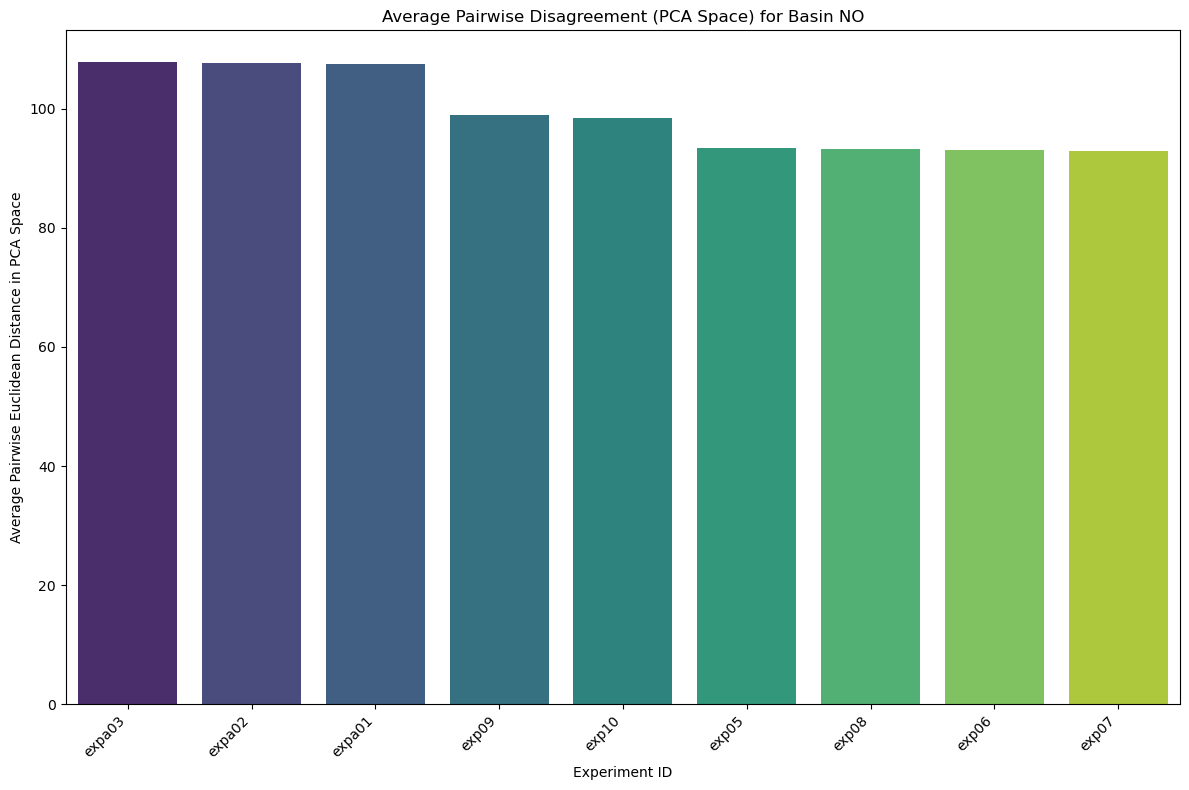

  Generated Disagreement Score Bar Chart for Basin NO

--- Processing Basin: NE (ID: 2) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NE, Experiment expa03
  Generated ARI Heatmap for Basin NE


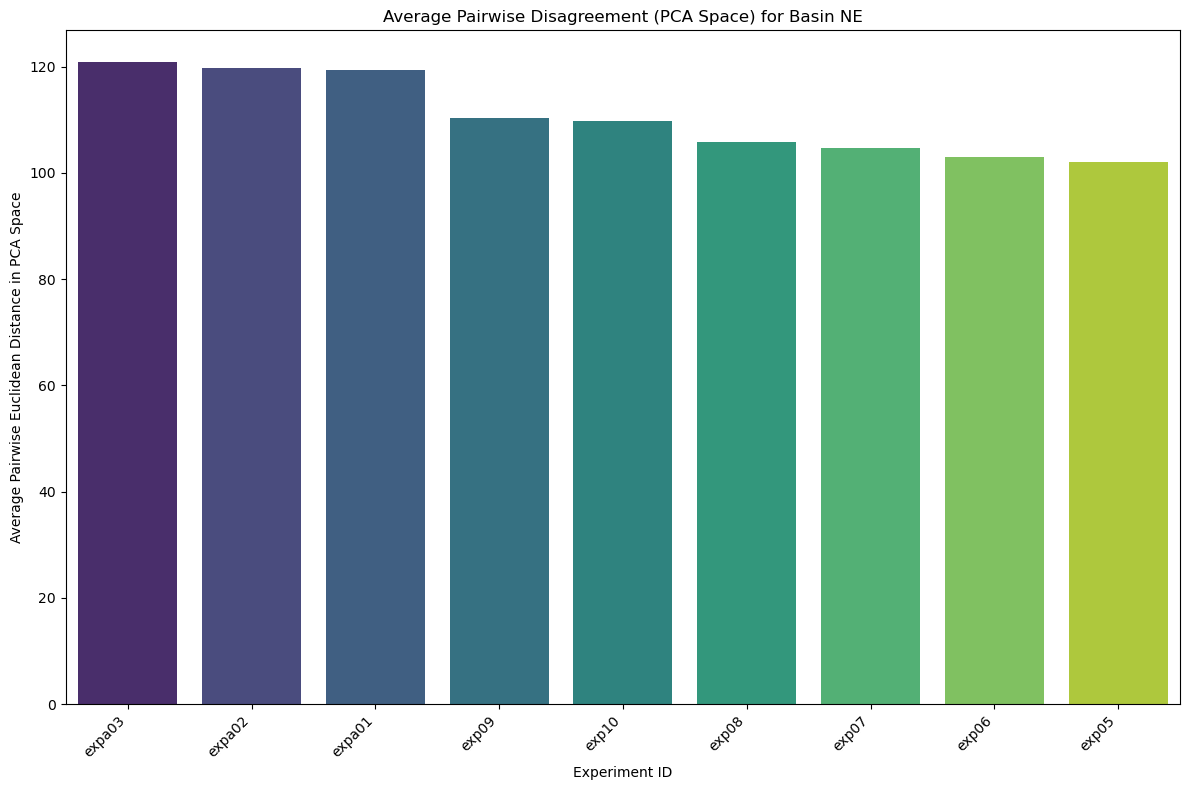

  Generated Disagreement Score Bar Chart for Basin NE

--- Processing Basin: CE (ID: 3) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CE, Experiment expa03
  Generated ARI Heatmap for Basin CE


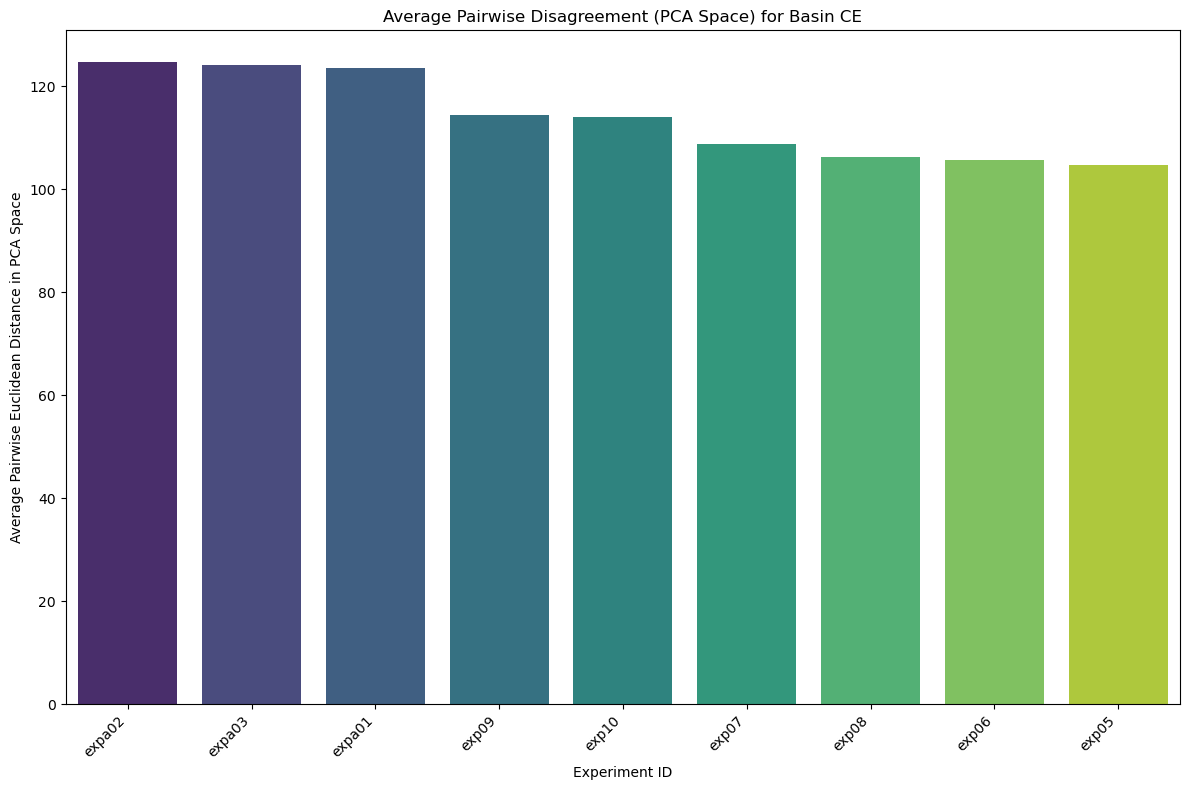

  Generated Disagreement Score Bar Chart for Basin CE

--- Processing Basin: SE (ID: 4) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SE, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SE, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SE, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SE, Experiment expa03
  Generated ARI Heatmap for Basin SE


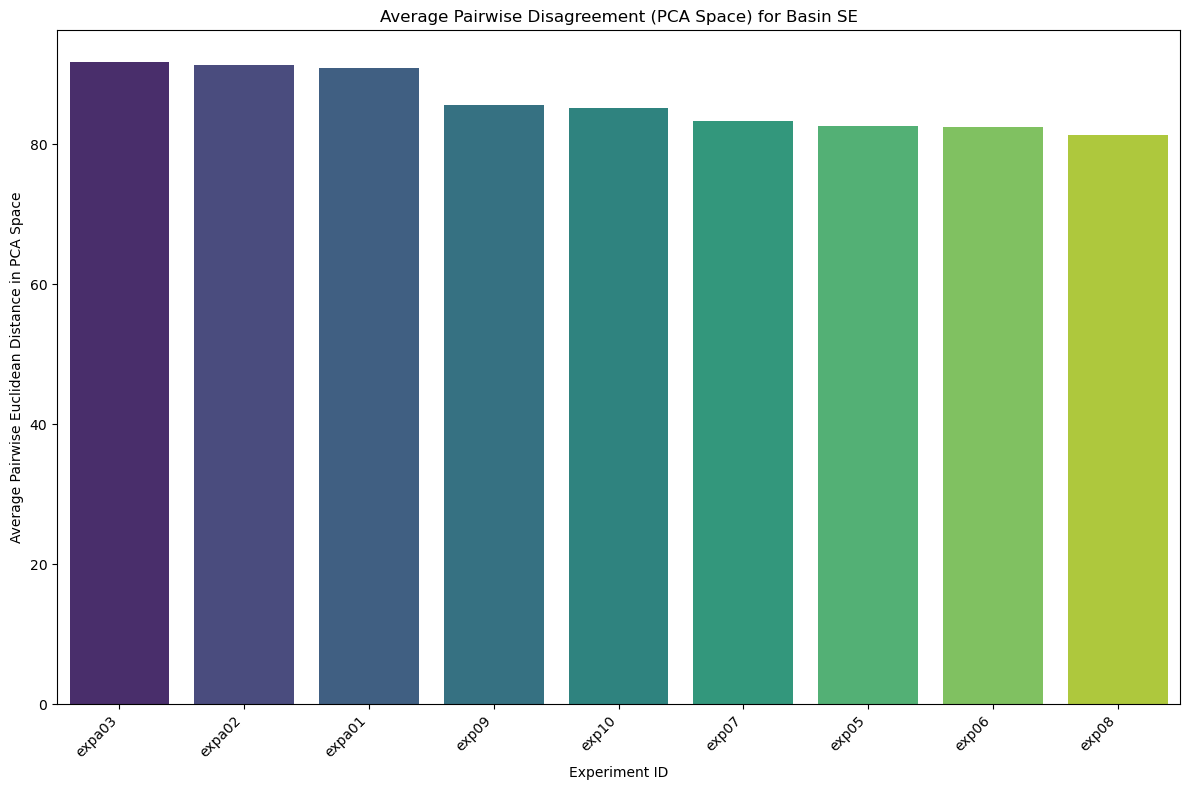

  Generated Disagreement Score Bar Chart for Basin SE

--- Processing Basin: SW (ID: 5) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin SW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin SW, Experiment expa03
  Generated ARI Heatmap for Basin SW


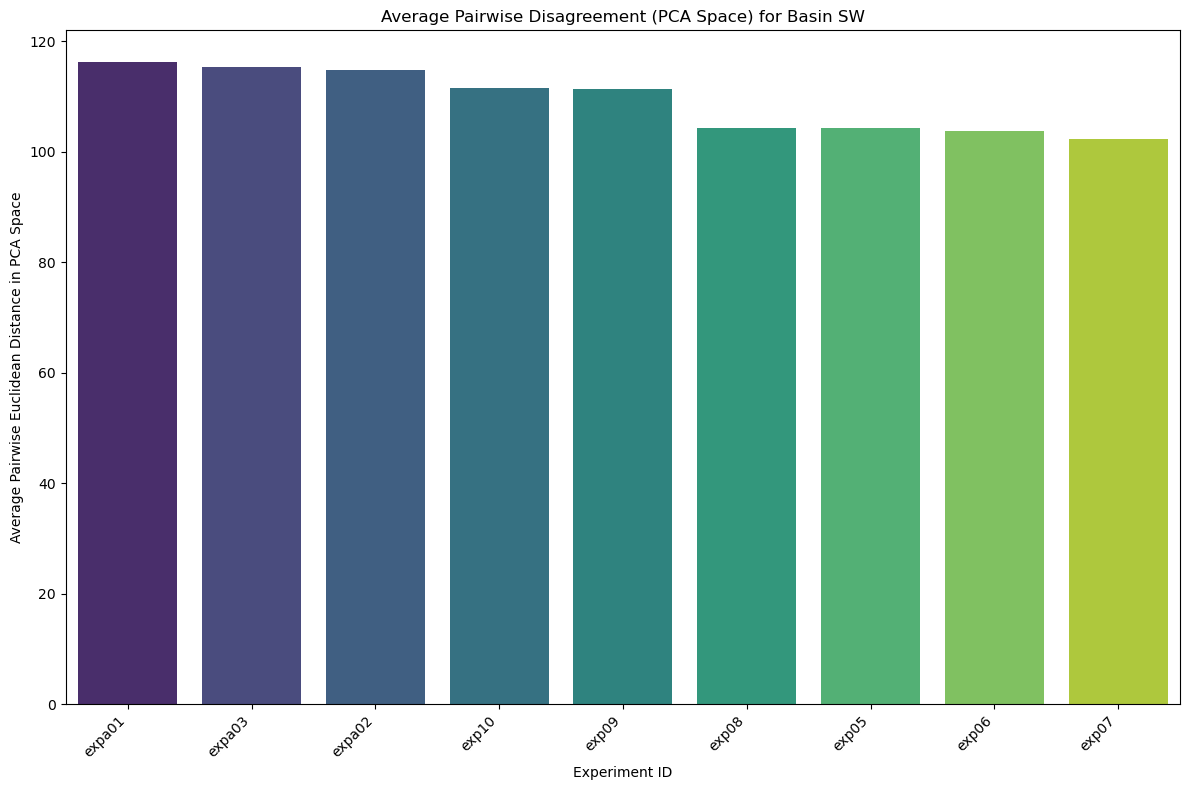

  Generated Disagreement Score Bar Chart for Basin SW

--- Processing Basin: CW (ID: 6) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin CW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin CW, Experiment expa03
  Generated ARI Heatmap for Basin CW


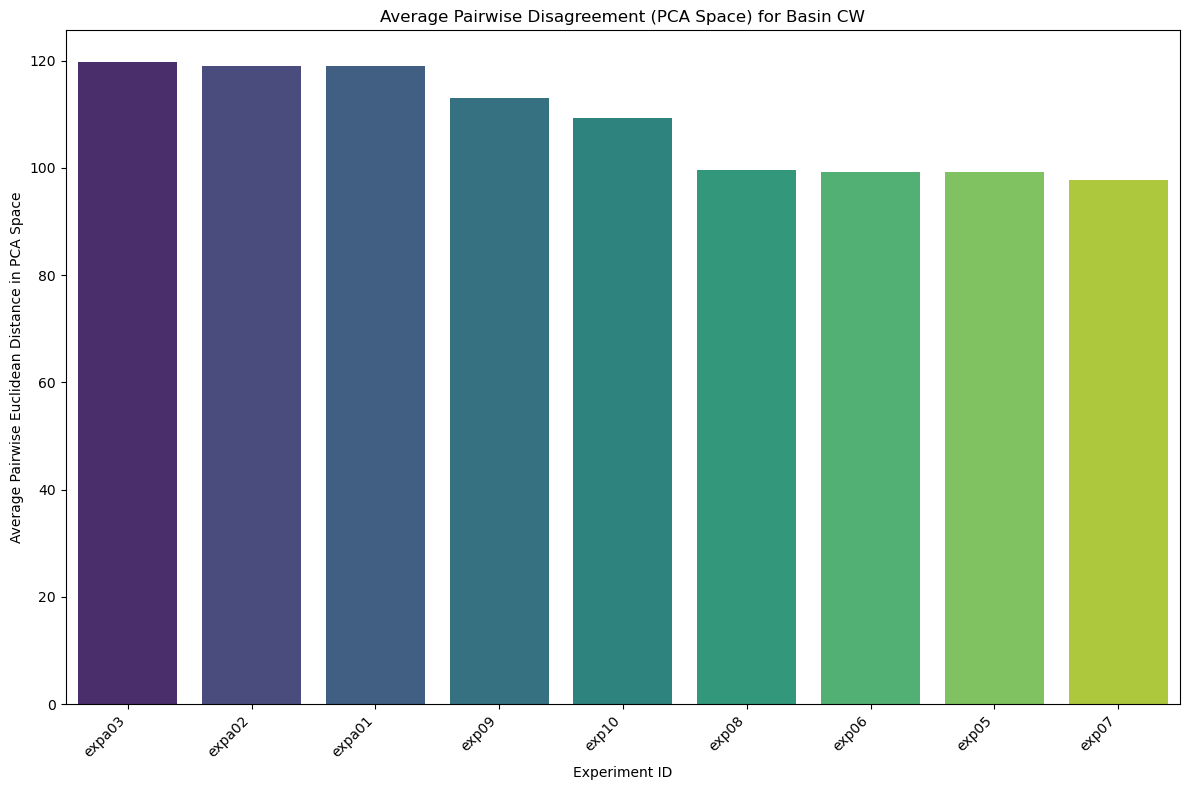

  Generated Disagreement Score Bar Chart for Basin CW

--- Processing Basin: NW (ID: 7) ---
  Processing Experiment: exp05


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp05
  Processing Experiment: exp06


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp06
  Processing Experiment: exp07


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp07
  Processing Experiment: exp08


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp08
  Processing Experiment: exp09


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp09
  Processing Experiment: exp10


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OM

  Generated PCA plot for Basin NW, Experiment exp10
  Processing Experiment: expa01


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NW, Experiment expa01
  Processing Experiment: expa02


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NW, Experiment expa02
  Processing Experiment: expa03


C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  model_ds = xr.open_dataset(model_file_path)
C:\Users\benra\AppData\Local\Temp\ipykernel_27320\2871396845.py:147: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this wa

  Generated PCA plot for Basin NW, Experiment expa03
  Generated ARI Heatmap for Basin NW


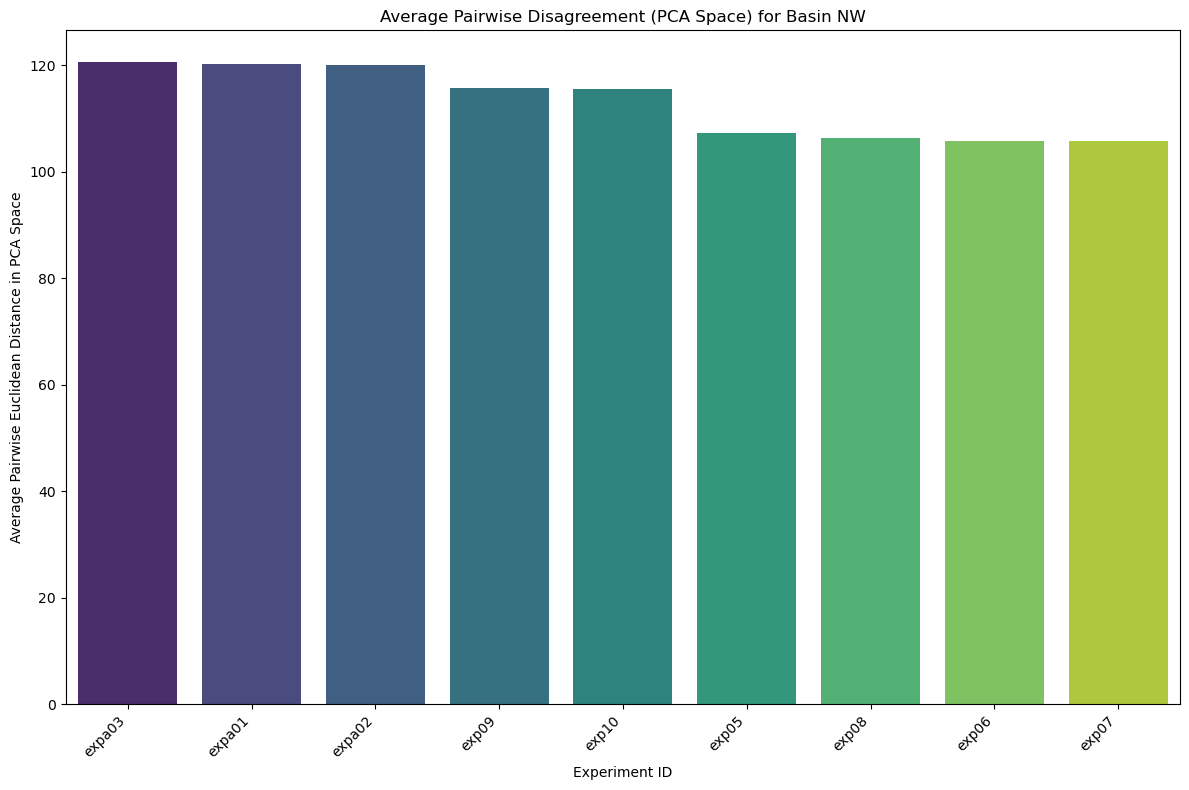

  Generated Disagreement Score Bar Chart for Basin NW

--- Analysis Complete ---


In [1]:
# --- Disagreement Score Calc/Plot with Average Distance Between Models in PCA Space ---

import os
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize 
from matplotlib.patches import Ellipse
import scipy.stats as stats 
from itertools import combinations 

# --- Configuration ---
# Base directory where your experiment folders are located
base_data_dir = r"C:\Users\benra"
# Path to your basin mask NetCDF file
basin_mask_path = r"C:\Users\benra\output_combined_masked_basins.nc"

# List of all experiment IDs (folder names)
experiment_ids = [
    'exp05', 'exp06', 'exp07', 'exp08', 'exp09', 'exp10', 'expa01', 'expa02', 'expa03'
]

# List of all model names (NetCDF file names within each experiment folder, without .nc)
# Ensure this list is comprehensive for all models across all experiments
participating_models = [
    'AWI_ISSM1', 'AWI_ISSM2', 'AWI_ISSM3', 'BGC_BISICLES', 'GSFC_ISSM',
    'ILTS_PIK_SICOPOLIS1', 'ILTS_PIK_SICOPOLIS2', 'IMAU_IMAUICE1', 'IMAU_IMAUICE2', 'JPL_ISSM',
    'JPL_ISSMPALEO', 'LSCE_GRISLI', 'MUN_GSM1', 'MUN_GSM2', 'NCAR_CISM',
    'UAF_PISM1', 'UAF_PISM2', 'UCIJPL_ISSM1', 'UCIJPL_ISSM2', 'VUB_GISM', 'VUW_PISM'
]


# Variable name for ice thickness in your NetCDF files
variable_name = 'lithk' # Assuming 'lithk' for ice thickness

# PCA and K-means parameters
n_components_pca = 4  # For 2D plotting and clustering
n_clusters_kmeans = 5 # Number of clusters for K-means

# Output directory for plots
output_plots_dir = "Basin_ARI_Analysis_Plots"
os.makedirs(output_plots_dir, exist_ok=True)

# --- Basin Geographic Names Mapping ---
basin_names = {
    1: 'NO',
    2: 'NE',
    3: 'CE',
    4: 'SE',
    5: 'SW',
    6: 'CW',
    7: 'NW'
}

# --- Define Marker Styles for Models ---
# Create a list of distinct markers to cycle through for each model
# Ensure you have enough markers for all your participating_models
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'h', 'v', '<', '>', 'p', 'H', 'd', '8', 'v', '^', '<', '>', 'P', '+']
model_to_marker = {model: markers[i % len(markers)] for i, model in enumerate(participating_models)}

# --- Load Basin Mask ---
try:
    basin_mask_data = xr.open_dataset(basin_mask_path)
    # --- DEBUGGING: Print all data variables to confirm 'IDs' name ---
    print(f"Data variables found in basin mask file: {list(basin_mask_data.data_vars.keys())}")

    # Attempt to load 'IDs' variable, stripping any potential whitespace from its name
    # This handles cases where the name might be 'IDs ' or ' IDs'
    basin_id_var_name = None
    for var_key in basin_mask_data.data_vars.keys():
        if var_key.strip() == 'IDs':
            basin_id_var_name = var_key
            break
    
    if basin_id_var_name is None:
        raise KeyError("Could not find 'IDs' variable (even after stripping whitespace) in basin mask NetCDF.")

    basin_ids_grid = basin_mask_data[basin_id_var_name]
    unique_basin_ids = np.unique(basin_ids_grid.values[~np.isnan(basin_ids_grid.values)]).astype(int)
    print(f"Found {len(unique_basin_ids)} unique basins: {unique_basin_ids}")

    # Get grid coordinates and shape from the basin mask (assuming it's on the same grid)
    x_coords_grid = basin_ids_grid['x'].values if 'x' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[1]].values
    y_coords_grid = basin_ids_grid['y'].values if 'y' in basin_ids_grid.coords else basin_ids_grid.coords[basin_ids_grid.dims[0]].values
    rows_grid, cols_grid = basin_ids_grid.shape
except FileNotFoundError:
    print(f"Error: Basin mask file not found at {basin_mask_path}")
    exit()
except KeyError as e:
    print(f"Error: {e}. Please check the variable name or file path for the basin mask.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading basin mask: {e}")
    exit()


# --- Main Analysis Loop: Per Basin ---
for basin_id in unique_basin_ids:
    # Get the geographic name for the current basin, default to number if not found
    basin_geo_name = basin_names.get(basin_id, f"Basin {basin_id}")
    print(f"\n--- Processing Basin: {basin_geo_name} (ID: {basin_id}) ---")

    # Dictionary to store cluster labels AND the list of models present for each experiment for the current basin
    # Key: experiment_id, Value: tuple (numpy array of cluster labels, list of model names)
    basin_experiment_clustering_results = {} # RENAMED for clarity

    # Dictionary to store average pairwise distances for each experiment
    basin_experiment_disagreement_scores = {}

    # Create a directory for basin-specific plots
    # Use the geographic name for the folder for better organization
    basin_output_dir = os.path.join(output_plots_dir, f"Basin_{basin_geo_name}")
    os.makedirs(basin_output_dir, exist_ok=True)

    # Dictionary to store PCA scores for plotting (for the 2D clustering plot)
    basin_experiment_pca_scores = {}

    # Loop through each experiment for the current basin
    for exp_id in experiment_ids:
        print(f"  Processing Experiment: {exp_id}")
        current_experiment_basin_deltas = []
        current_experiment_models_present = [] # Keep track of models actually loaded

        # Construct the actual folder name for the current experiment
        experiment_folder_name = f"{variable_name}_{exp_id}" # e.g., 'lithk_exp05'

        # Loop through each model in the current experiment
        for model_name in participating_models:
            # --- Construct the model file name based on naming convention ---
            # Example: lithk_GIS_AWI-ISSM1_exp05.nc
            model_file_name = f"{variable_name}_GIS_{model_name}_{exp_id}.nc"
            model_file_path = os.path.join(base_data_dir, experiment_folder_name, model_file_name)

            if not os.path.exists(model_file_path):
                # print(f"    Warning: Model file not found for {model_name} in {exp_id}. Skipping.")
                continue # Skip this model if its file doesn't exist

            try:
                model_ds = xr.open_dataset(model_file_path)
                # Ensure 'time' dimension exists and is sufficient
                if 'time' not in model_ds[variable_name].dims or len(model_ds['time']) < 2:
                    print(f"    Warning: '{variable_name}' in {model_name}/{exp_id} has insufficient time dimension. Skipping.")
                    model_ds.close()
                    continue

                # Calculate delta lithk from 2015 (index 0) to 2100 (last index)
                # Assuming time dimension is sorted and 2015 is first, 2100 is last.
                delta_lithk = model_ds[variable_name].isel(time=-1) - model_ds[variable_name].isel(time=0)

                # Close dataset to free memory
                model_ds.close()

                # --- FIX FOR MEMORYERROR: Ensure spatial alignment before masking ---
                # Rename dimensions of delta_lithk to match basin_ids_grid
                target_dims = basin_ids_grid.dims
                
                if len(delta_lithk.dims) == len(target_dims):
                    dim_rename_map = {old_dim: new_dim for old_dim, new_dim in zip(delta_lithk.dims, target_dims)}
                    delta_lithk_aligned = delta_lithk.rename(dim_rename_map)
                else:
                    print(f"    Warning: Delta_lithk for {model_name} in {exp_id} has unexpected dimensions: {delta_lithk.dims}. Skipping alignment.")
                    delta_lithk_aligned = delta_lithk

                delta_lithk_reindexed = delta_lithk_aligned.reindex_like(basin_ids_grid, method='nearest', tolerance=1e-6)

                # Now apply the mask using the reindexed delta_lithk
                basin_specific_delta = delta_lithk_reindexed.where(basin_ids_grid == basin_id)

                # Flatten the 2D basin-specific delta to a 1D array
                flattened_delta = basin_specific_delta.values.flatten()
                current_experiment_basin_deltas.append(flattened_delta)
                current_experiment_models_present.append(model_name)

            except Exception as e:
                print(f"    Error processing {model_name} in {exp_id}: {e}. Skipping.")
                if 'model_ds' in locals() and model_ds is not None:
                    model_ds.close()
                continue

        if not current_experiment_models_present:
            print(f"  No valid model data found for Experiment {exp_id} in Basin {basin_id}. Skipping clustering.")
            continue # Skip clustering for this experiment if no data

        # Stack all models' basin-specific deltas into a matrix
        all_models_basin_data = np.stack(current_experiment_basin_deltas)

        # Handle NaNs: Remove grid points that are NaN for *any* model in this basin/experiment
        mask_valid_points = ~np.any(np.isnan(all_models_basin_data), axis=0)
        data_matrix_for_clustering = all_models_basin_data[:, mask_valid_points]

        if data_matrix_for_clustering.shape[1] == 0:
            print(f"  No valid (non-NaN) data points for clustering in Experiment {exp_id}, Basin {basin_id}. Skipping.")
            continue # Skip if no valid spatial points remain after masking

        # --- Perform PCA ---
        scaler = StandardScaler()
        data_matrix_scaled = scaler.fit_transform(data_matrix_for_clustering)

        pca = PCA(n_components=n_components_pca)
        pca_scores = pca.fit_transform(data_matrix_scaled)
        basin_experiment_pca_scores[exp_id] = pca_scores # Store for plotting

        # --- NEW: Calculate average pairwise distance for this experiment's ensemble ---
        if pca_scores.shape[0] >= 2: # Need at least 2 models to calculate pairwise distances
            pairwise_distances = []
            for m1, m2 in combinations(range(pca_scores.shape[0]), 2):
                dist = np.linalg.norm(pca_scores[m1] - pca_scores[m2])
                pairwise_distances.append(dist)
            avg_pairwise_distance = np.mean(pairwise_distances)
            basin_experiment_disagreement_scores[exp_id] = avg_pairwise_distance
        else:
            basin_experiment_disagreement_scores[exp_id] = np.nan # Not enough models for meaningful distance

        # --- Perform K-Means Clustering ---
        kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(pca_scores)
        
        # Store both labels and the list of models present for this experiment
        basin_experiment_clustering_results[exp_id] = (labels, current_experiment_models_present)


        # --- Generate 2D PCA Plot for this Basin/Experiment ---
        fig_2d, ax_2d = plt.subplots(figsize=(12, 10)) # Increased figure size for legend

        # Define cluster colors (matching viridis cmap)
        cluster_colors = [plt.cm.viridis(i / (n_clusters_kmeans - 1)) for i in range(n_clusters_kmeans)]

        # Loop through models present in THIS experiment to ensure correct labels and plotting
        for i, model_name in enumerate(current_experiment_models_present):
            cluster_id = labels[i]
            color = cluster_colors[cluster_id]
            marker = model_to_marker[model_name]

            ax_2d.scatter(
                pca_scores[i, 0],
                pca_scores[i, 1],
                c=[color],
                marker=marker,
                label=None, # Labels are for custom legend handles below
                s=250, # Increased marker size
                edgecolor='black',
                alpha=0.8
            )

        # --- Add Ellipses for each Cluster in 2D Plot ---
        # Chi-squared critical value for 95% confidence with 2 degrees of freedom
        confidence_level = 0.95
        chi2_val = stats.chi2.ppf(confidence_level, df=2)

        for cluster_id in np.unique(labels):
            cluster_points = pca_scores[labels == cluster_id, :2] # Select points for this cluster (PC1, PC2)

            if len(cluster_points) < 2: # Need at least 2 points to compute covariance for an ellipse
                continue

            centroid = np.mean(cluster_points, axis=0)
            covariance = np.cov(cluster_points, rowvar=False)

            eigenvalues, eigenvectors = np.linalg.eigh(covariance)

            # Sort eigenvalues and eigenvectors in descending order for correct orientation
            order = eigenvalues.argsort()[::-1]
            eigenvalues = eigenvalues[order]
            eigenvectors = eigenvectors[:, order]

            # Calculate angle of rotation for the ellipse
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

            # Calculate width and height of the ellipse axes
            width = 2 * np.sqrt(eigenvalues[0] * chi2_val) # Major axis
            height = 2 * np.sqrt(eigenvalues[1] * chi2_val) # Minor axis

            ellipse_color = cluster_colors[cluster_id]
            ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, edgecolor=ellipse_color, fc='None',
                              lw=2, alpha=0.7, zorder=0) # zorder to keep it behind points
            ax_2d.add_patch(ellipse)

        # Create a custom legend for clusters and models
        # For clusters
        cluster_legend_handles = []
        for i in range(n_clusters_kmeans):
            cluster_legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                                     markerfacecolor=cluster_colors[i], markersize=10,
                                                     label=f'Cluster {i}'))

        # For models - ENSURE MARKER COLOR MATCHES PLOT COLOR
        model_legend_handles = []
        for i, model_name in enumerate(current_experiment_models_present): # Use current_experiment_models_present
            cluster_id = labels[i] # Get the cluster ID for the current model
            model_color = cluster_colors[cluster_id] # Get the color associated with that cluster
            model_legend_handles.append(plt.Line2D([0], [0], marker=model_to_marker[model_name], color='w',
                                                   markerfacecolor=model_color, # Use the model's cluster color here
                                                   markersize=10,
                                                   label=model_name, markeredgecolor='black'))

        # Add the cluster legend
        first_legend = ax_2d.legend(handles=cluster_legend_handles, loc='upper left', title='Clusters', bbox_to_anchor=(1.02, 1))
        ax_2d.add_artist(first_legend) # Add the first legend manually to allow a second one

        # Add the model legend
        ax_2d.legend(handles=model_legend_handles, loc='lower left', title='Models', bbox_to_anchor=(1.02, 0))


        ax_2d.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
        ax_2d.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
        plt.title(f'PCA Clustering for Basin {basin_geo_name}, Experiment {exp_id}')
        plt.grid(True, linestyle='--', alpha=0.6) # Keep grid
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

        # Save 2D plot
        plt.savefig(os.path.join(basin_output_dir, f'PCA_Clustering_Basin_{basin_geo_name}_Exp_{exp_id}.png'))
        plt.close(fig_2d) # Close the figure to free memory

        print(f"  Generated PCA plot for Basin {basin_geo_name}, Experiment {exp_id}")

    # --- Generate ARI Heatmap for the current basin (after processing all experiments) ---
    # Use basin_experiment_clustering_results to get both labels and model lists
    if len(basin_experiment_clustering_results) < 2:
        print(f"  Not enough experiments with valid clustering results for Basin {basin_id} to compute ARI heatmap. Skipping.")
        # Also skip disagreement plot if not enough data
        if len(basin_experiment_disagreement_scores) < 2:
            print(f"  Not enough experiments with valid disagreement scores for Basin {basin_id} to plot. Skipping.")
        continue

    # Filter experiment_ids to only include those that had valid clustering results
    experiments_with_valid_results = list(basin_experiment_clustering_results.keys())
    ari_matrix = np.zeros((len(experiments_with_valid_results), len(experiments_with_valid_results)))
    ari_df = pd.DataFrame(ari_matrix, index=experiments_with_valid_results, columns=experiments_with_valid_results)

    for i, exp1_id in enumerate(experiments_with_valid_results):
        for j, exp2_id in enumerate(experiments_with_valid_results):
            labels1_full, models1 = basin_experiment_clustering_results[exp1_id]
            labels2_full, models2 = basin_experiment_clustering_results[exp2_id]
            
            # Find common models between the two experiments
            common_models = sorted(list(set(models1).intersection(set(models2))))

            if len(common_models) < 2: # Need at least 2 common models to compute ARI
                ari_score = np.nan
            else:
                # Create aligned label arrays for only the common models
                # Map model names to their original indices to get correct labels
                model_to_idx1 = {model: idx for idx, model in enumerate(models1)}
                model_to_idx2 = {model: idx for idx, model in enumerate(models2)}
                
                labels1_common = [labels1_full[model_to_idx1[m]] for m in common_models]
                labels2_common = [labels2_full[model_to_idx2[m]] for m in common_models]
                
                ari_score = adjusted_rand_score(labels1_common, labels2_common)
            
            ari_df.iloc[i, j] = ari_score

    # Plotting the ARI Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(ari_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, linecolor='black')
    plt.title(f'Adjusted Rand Index (ARI) Heatmap for Basin {basin_geo_name} Clusterings (Common Models)') # Use geo name in title
    plt.xlabel('Experiment ID')
    plt.ylabel('Experiment ID')
    plt.tight_layout()
    plt.savefig(os.path.join(basin_output_dir, f'ARI_Heatmap_Basin_{basin_geo_name}.png')) # Use geo name in filename
    plt.close()
    print(f"  Generated ARI Heatmap for Basin {basin_geo_name}")

    # --- Generate Disagreement Score Bar Chart for the current basin ---
    if len(basin_experiment_disagreement_scores) > 0:
        disagreement_series = pd.Series(basin_experiment_disagreement_scores).sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=disagreement_series.index, y=disagreement_series.values, palette='viridis')
        plt.title(f'Average Pairwise Disagreement (PCA Space) for Basin {basin_geo_name}')
        plt.xlabel('Experiment ID')
        plt.ylabel('Average Pairwise Euclidean Distance in PCA Space')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(basin_output_dir, f'Disagreement_Bar_Basin_{basin_geo_name}.png'))
        plt.show()
        print(f"  Generated Disagreement Score Bar Chart for Basin {basin_geo_name}")
    else:
        print(f"  No valid disagreement scores to plot for Basin {basin_id}. Skipping bar chart.")


print("\n--- Analysis Complete ---")
